In [55]:
import numpy as np
from phy.io.h5 import open_h5

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
%ls data

20141215_all.kwik*  20141215_all.kwx*


In [99]:
basename = '20141009_all_AdjGraph'
kwik = open_h5('data/%s.kwik' % basename)
kwx = open_h5('data/%s.kwx' % basename)
kwd = open_h5('data/%s.raw.kwd' % basename)

In [184]:
rate = kwik.read_attr('/application_data/spikedetekt', 'sample_rate')

In [133]:
spike_times = kwik.read('/channel_groups/1/spikes/time_samples')[:]

In [100]:
spike_clusters = kwik.read('/channel_groups/1/spikes/clusters/main')[:]

In [105]:
all_clusters = np.unique(spike_clusters)

In [111]:
clusters = [6]

In [112]:
myspikes = np.in1d(spike_clusters, clusters)

In [117]:
waveforms = kwx.read('/channel_groups/1/waveforms_filtered')
masks = kwx.read('/channel_groups/1/features_masks')

In [118]:
mywaveforms = waveforms[myspikes,:,:]
mymasks = masks[myspikes,:,1]

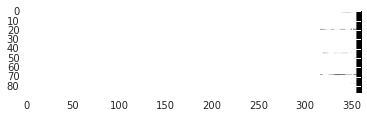

In [124]:
plt.imshow(mymasks);

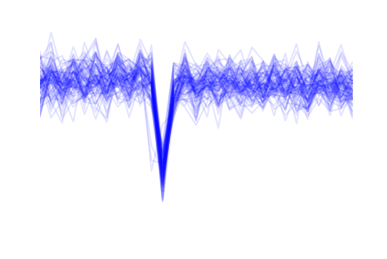

In [128]:
plt.plot(mywaveforms[...,119].T, '-b', alpha=.1);
plt.axis('off');

In [130]:
mydata = kwd.read('/recordings/0/data')

In [132]:
mydata.shape[0]/20000.

361.6875

In [135]:
my_spike_times = spike_times[myspikes]

In [188]:
from scipy import signal

def bandpass_filter(rate):
    low = 500.
    high = 0.95 * .5 * rate
    order = 3
    return signal.butter(order,
                         (low/(rate/2.), high/(rate/2.)),
                         'pass')

def apply_filter(x, filter=None):
    if x.shape[0] == 0:
        return x
    b, a = filter
    try:
        out_arr = signal.filtfilt(b, a, x, axis=0)
    except TypeError:
        out_arr = np.zeros_like(x)
        for i_ch in range(x.shape[1]):
            out_arr[:, i_ch] = signal.filtfilt(b, a, x[:, i_ch])
    return out_arr

In [189]:
filter = bandpass_filter(rate)

In [199]:
%%timeit
for time in my_spike_times:
    time = int(time)
    wave = mydata[time-50:time+50,:-20]
    wavef = apply_filter(wave, filter)

In [230]:
time += 10000

In [232]:
%timeit -r1 -n1 mydata[time-50:time+50,:-20]

1 loops, best of 1: 222 µs per loop


In [210]:
time = int(my_spike_times[2])
wave = mydata[time-50:time+50,:-20]
wavef = apply_filter(wave, filter)

In [233]:
%%timeit
wavef = apply_filter(wave, filter)

1000 loops, best of 3: 1.17 ms per loop


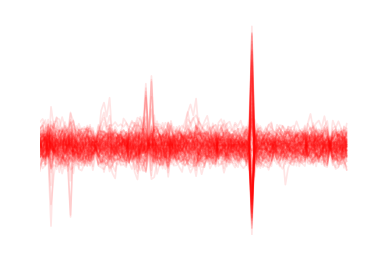

In [217]:
plt.plot(wavef.T, '-r', alpha=.1);
#plt.plot(wave, '-b', alpha=.1);
plt.axis('off');

In [234]:
1000*20000/1024.**2

19.073486328125

In [94]:
kwik.close()
kwx.close()
kwd.close()